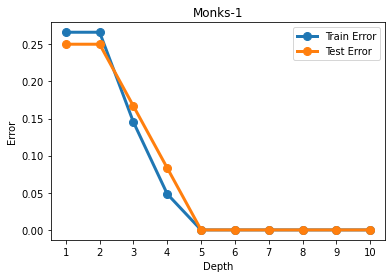

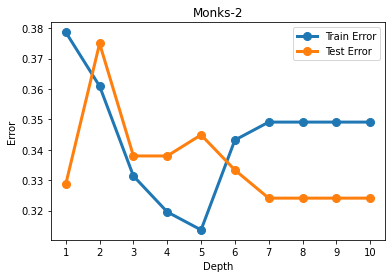

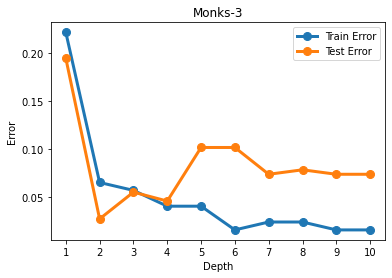

In [5]:
###############################################################################################################################################
# CS6375.001 Machine Learning - Assignment 2 - Decision Tree
# Name: Karneeshwar Sendilkumar Vijaya
# NetID: KXS200001
###############################################################################################################################################

# Part-B Solution

import numpy as np
import os
import graphviz
import math

def partition(x):
    """
    Partition the column vector x into subsets indexed by its unique values_data (v1, ... vk)

    Returns a dictionary of the form
    { v1: indices of x == v1,
      v2: indices of x == v2,
      ...
      vk: indices of x == vk }, where [v1, ... vk] are all the unique values_data in the vector z.
    """
    parts = {}
    i = 0
    
    for j in x:
        if j in parts:
            parts[j].append(i)
        else:
            parts[j] = [i]
        i += 1
    return parts

    raise Exception('Function not yet implemented!')
    
def entropy(y):
    """
    Compute the entropy of a vector y by considering the counts of the unique values_data (v1, ... vk), in z

    Returns the entropy of z: H(z) = p(z=v1) log2(p(z=v1)) + ... + p(z=vk) log2(p(z=vk))
    """

    ent=0;
    valuesy,county = np.unique(y,return_counts = True)
    
    for z in county:
        ent = ent + ((z/len(y))*(math.log(z/len(y),2)))
        
    return -ent

    raise Exception('Function not yet implemented!')


def mutual_information(x, y):
    """
    Compute the mutual information between a data column (x) and the labels (y). The data column is a single attribute
    over all the examples (n x 1). Mutual information is the difference between the entropy BEFORE the split set, and
    the weighted-average entropy of EACH possible split.

    Returns the mutual information: I(x, y) = H(y) - H(y | x)
    """

    Mutual_Information = {}
    values_data, counts = np.unique(x, return_counts=True) 
    Entropy_y = entropy(y)

    for v in values_data:  
        ny1 = y[np.where(x == v)]
        ny2 = y[np.where(x != v)]
        Mutual_Information[v] = (Entropy_y - ((len(ny1)/len(y)*entropy(ny1)) + (len(ny2)/len(y)*entropy(ny2))))
    return Mutual_Information

    raise Exception('Function not yet implemented!')


def id3(x, y, attribute_value_pairs=None, depth=0, max_depth=5):
    """
    Implements the classical ID3 algorithm given training data (x), training labels (y) and an array of
    attribute-value pairs to consider. This is a recursive algorithm that depends on three termination conditions
        1. If the entire set of labels (y) is pure (all y = only 0 or only 1), then return that label
        2. If the set of attribute-value pairs is empty (there is nothing to split on), then return the most common
           value of y (majority label)
        3. If the max_depth is reached (pre-pruning bias), then return the most common value of y (majority label)
    Otherwise the algorithm selects the next best attribute-value pair using INFORMATION GAIN as the splitting criterion
    and partitions the data set based on the values_data of that attribute before the next recursive call to ID3.

    The tree we learn is a BINARY tree, which means that every node has only two branches. The splitting criterion has
    to be chosen from among all possible attribute-value pairs. That is, for a problem with two features/attributes x1
    (taking values_data a, b, c) and x2 (taking values_data d, e), the initial attribute value pair list is a list of all pairs of
    attributes with their corresponding values_data:
    [(x1, a),
     (x1, b),
     (x1, c),
     (x2, d),
     (x2, e)]
     If we select (x2, d) as the best attribute-value pair, then the new decision node becomes: [ (x2 == d)? ] and
     the attribute-value pair (x2, d) is removed from the list of attribute_value_pairs.

    The tree is stored as a nested dictionary, where each entry is of the form
                    (attribute_index, attribute_value, True/False): subtree
    * The (attribute_index, attribute_value) determines the splitting criterion of the current node. For example, (4, 2)
    indicates that we test if (x4 == 2) at the current node.
    * The subtree itself can be nested dictionary, or a single label (leaf node).
    * Leaf nodes are (majority) class labels

    Returns a decision tree represented as a nested dictionary, for example
    {(4, 1, False):
        {(0, 1, False):
            {(1, 1, False): 1,
             (1, 1, True): 0},
         (0, 1, True):
            {(1, 1, False): 0,
             (1, 1, True): 1}},
     (4, 1, True): 1}
    """
    values_data = np.unique(y)
    
    if len(values_data) == 1: 
        return values_data[0]
    
    if attribute_value_pairs == 0:
        values_data, counts = np.unique(y, return_counts=True)
        return values_data[np.argmax(counts)]
    
    if depth == max_depth:
        values_data, counts = np.unique(y, return_counts=True)
        return values_data[np.argmax(counts)]
    
    decision_tree = {}
    gain_max_att = 0
    max_att = 0
    max_att_value = 0
    for att, att_value in attribute_value_pairs:
        MI = mutual_information(x[:,att], y)
        gain_att_value = MI.get(att_value)
        if gain_att_value == None:
            continue
            
        max_gain_MI = gain_att_value
        max_value_MI = att_value
        if ((max_gain_MI > gain_max_att)):
            gain_max_att = max_gain_MI 
            max_att = att
            max_att_value = max_value_MI
    
    if((gain_max_att != 0) or (max_att != 0) or (max_att_value != 0)):
        attribute_value_pairs.remove((max_att, max_att_value))
        true_side = (max_att, max_att_value, True)
        false_side = (max_att, max_att_value, False)
        partition_x = partition(x[:,max_att])
        x_att_indices = partition_x[max_att_value]
        false_y = y[np.where(x[: ,max_att] != max_att_value)]
        false_x = x[np.where(x[: ,max_att] != max_att_value)]
        a = id3(x[x_att_indices], y[x_att_indices], attribute_value_pairs, depth+1, max_depth)
        b = id3(false_x, false_y, attribute_value_pairs, depth+1, max_depth)
        decision_tree = {true_side: a, false_side: b}
    else:
        values_data, counts = np.unique(y, return_counts = True)
        return values_data[np.argmax(counts)]
    return decision_tree
    
    raise Exception('Function not yet implemented!')


def predict_example(x, tree):
    """
    Predicts the classification label for a single example x using tree by recursively descending the tree until
    a label/leaf node is reached.

    Returns the predicted label of x according to tree
    """

    for split, subtree in tree.items():
        att_num = split[0]
        att_value = split[1]
        d = split[2]

        if d == (x[att_num] == att_value):
            if type(subtree) is dict:
                return predict_example(x, subtree)
            else:
                return subtree
            
    raise Exception('Function not yet implemented!')


def compute_error(y_true, y_pred):
    """
    Computes the average error between the true labels (y_true) and the predicted labels (y_pred)

    Returns the error = (1/n) * sum(y_true != y_pred)
    """

    length = len(y_true)
    err = [y_true[i] != y_pred[i] for i in range(length)]
    return sum(err)/length

    raise Exception('Function not yet implemented!')


def pretty_print(tree, depth=0):
    """
    Pretty prints the decision tree to the console. Use print(tree) to print the raw nested dictionary representation
    DO NOT MODIFY THIS FUNCTION!
    """
    if depth == 0:
        print('TREE')

    for index, split_criterion in enumerate(tree):
        sub_trees = tree[split_criterion]

        # Print the current node: split criterion
        print('|\t' * depth, end='')
        print('+-- [SPLIT: x{0} = {1} {2}]'.format(split_criterion[0], split_criterion[1], split_criterion[2]))

        # Print the children
        if type(sub_trees) is dict:
            pretty_print(sub_trees, depth + 1)
        else:
            print('|\t' * (depth + 1), end='')
            print('+-- [LABEL = {0}]'.format(sub_trees))


def render_dot_file(dot_string, save_file, image_format='png'):
    """
    Uses GraphViz to render a dot file. The dot file can be generated using
        * sklearn.tree.export_graphviz()' for decision trees produced by scikit-learn
        * to_graphviz() (function is in this file) for decision trees produced by  your code.
    DO NOT MODIFY THIS FUNCTION!
    """
    if type(dot_string).__name__ != 'str':
        raise TypeError('visualize() requires a string representation of a decision tree.\nUse tree.export_graphviz()'
                        'for decision trees produced by scikit-learn and to_graphviz() for decision trees produced by'
                        'your code.\n')

    # Set path to your GraphViz executable here
    os.environ["PATH"] += os.pathsep + '/opt/homebrew/Cellar/graphviz/2.50.0/bin/'
    graph = graphviz.Source(dot_string)
    graph.format = image_format
    graph.render(save_file, view=True)


def to_graphviz(tree, dot_string='', uid=-1, depth=0):
    """
    Converts a tree to DOT format for use with visualize/GraphViz
    DO NOT MODIFY THIS FUNCTION!
    """

    uid += 1       # Running index of node ids across recursion
    node_id = uid  # Node id of this node

    if depth == 0:
        dot_string += 'digraph TREE {\n'

    for split_criterion in tree:
        sub_trees = tree[split_criterion]
        attribute_index = split_criterion[0]
        attribute_value = split_criterion[1]
        split_decision = split_criterion[2]

        if not split_decision:
            # Alphabetically, False comes first
            dot_string += '    node{0} [label="x{1} = {2}?"];\n'.format(node_id, attribute_index, attribute_value)

        if type(sub_trees) is dict:
            if not split_decision:
                dot_string, right_child, uid = to_graphviz(sub_trees, dot_string=dot_string, uid=uid, depth=depth + 1)
                dot_string += '    node{0} -> node{1} [label="False"];\n'.format(node_id, right_child)
            else:
                dot_string, left_child, uid = to_graphviz(sub_trees, dot_string=dot_string, uid=uid, depth=depth + 1)
                dot_string += '    node{0} -> node{1} [label="True"];\n'.format(node_id, left_child)

        else:
            uid += 1
            dot_string += '    node{0} [label="y = {1}"];\n'.format(uid, sub_trees)
            if not split_decision:
                dot_string += '    node{0} -> node{1} [label="False"];\n'.format(node_id, uid)
            else:
                dot_string += '    node{0} -> node{1} [label="True"];\n'.format(node_id, uid)

    if depth == 0:
        dot_string += '}\n'
        return dot_string
    else:
        return dot_string, node_id, uid


if __name__ == '__main__':
    
    train_e_1 = {}
    train_e_2 = {}
    train_e_3 = {}
    test_e_1 = {}
    test_e_2 = {}
    test_e_3 = {}
    
    for d in range(1,11):
        for n in range(1,4):
            # Load the training data
            training_set = './monks-' + str(n) + '.train'
            M = np.genfromtxt(training_set, missing_values=0, skip_header=0, delimiter=',', dtype=int)
            y_train = M[:, 0]
            x_train = M[:, 1:]
            
            # Load the test data
            test_set = './monks-' + str(n) + '.test'
            M = np.genfromtxt(test_set, missing_values=0, skip_header=0, delimiter=',', dtype=int)
            y_test = M[:, 0]
            x_test = M[:, 1:]
            
            #Getting attribute_value_pairs
            attribute_value_pairs = [] 
            for att in range(len(x_train[0])):
                values_data = np.unique(x_train[:,att])
                for v in range(len(values_data)):
                    attribute_value_pairs.append((att,values_data[v]))
                    
            decision_tree = id3(x_train, y_train, attribute_value_pairs, max_depth=d)
            
            # Compute the test error
            y_pred = [predict_example(x, decision_tree) for x in x_test]
            tst_err = compute_error(y_test, y_pred)
            if n == 1: test_e_1[d] = tst_err 
            if n == 2: test_e_2[d] = tst_err
            if n == 3: test_e_3[d] = tst_err
            
            # Compute the train error
            y_pred = [predict_example(x, decision_tree) for x in x_train]
            trn_err = compute_error(y_train, y_pred)
            if n == 1: train_e_1[d] = trn_err 
            if n == 2: train_e_2[d] = trn_err
            if n == 3: train_e_3[d] = trn_err
                
import matplotlib.pyplot as plt

for i in range(1, 4):
        plt.figure()
        plt.title("Monks-" + str(i))
        if i == 1:
            plt.plot(train_e_1.keys(), train_e_1.values(), marker='o', linewidth=3, markersize=8)
            plt.plot(test_e_1.keys(), test_e_1.values(), marker='o', linewidth=3, markersize=8)
        if i == 2:
            plt.plot(train_e_2.keys(), train_e_2.values(), marker='o', linewidth=3, markersize=8)
            plt.plot(test_e_2.keys(), test_e_2.values(), marker='o', linewidth=3, markersize=8)
        if i == 3:
            plt.plot(train_e_3.keys(), train_e_3.values(), marker='o', linewidth=3, markersize=8)
            plt.plot(test_e_3.keys(), test_e_3.values(), marker='o', linewidth=3, markersize=8)
        plt.xlabel('Depth')
        plt.ylabel('Error')
        plt.legend(['Train Error', 'Test Error'])
        plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    
###############################################################################################################################################